The cython extension is already loaded. To reload it, use:
  %reload_ext cython


/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


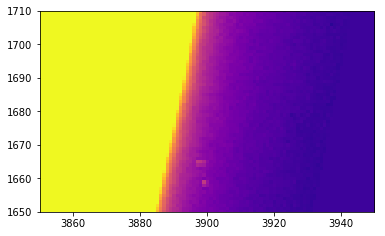

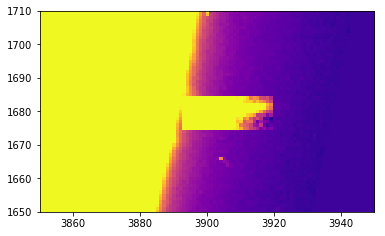

<Quantity 17.26313396578985>

In [3]:
%matplotlib inline
%load_ext cython
import matplotlib.pyplot as plt

#path = 'data/hmi_ic_45s_2013_05_13_16_00_00_tai_continuum.0.fits'

path_0 = 'data/hmi_ic_45s_2013_05_13_15_56_15_tai_continuum.fits'
path_1 = 'data/hmi_ic_45s_2013_05_13_16_00_45_tai_continuum.fits'

# path_1 = 'data/hmi_ic_45s_2013_05_13_16_00_00_tai_continuum.fits'
#path_1 = 'data/hmi_ic_45s_2013_05_13_16_00_45_tai_continuum.fits' # long faint


import sunpy.map 
m_0 = sunpy.map.Map(path_0)
m_1 = sunpy.map.Map(path_1)

import astropy.units as u
from astropy.constants import R_earth
import numpy as np

image_0 = m_0.data.copy()
image_1 = m_1.data.copy()

background = np.percentile(image_0[(image_0 < 500) & (image_0 > 100)], 10)
image_0[np.isnan(image_0)] = background
image_1[np.isnan(image_1)] = background

median = np.percentile(image_1[1675:1685, 3893:3920], 1)
image_1[1675:1685, 3893:3920] = 10*(image_1[1675:1685, 3893:3920] - median) + median

np.save('control_image.npy', image_0)
np.save('filament_image.npy', image_1)

plt.imshow(image_0, origin='lower', vmin=image_0.min(), vmax=1000, cmap=plt.cm.plasma)
plt.xlim([3850, 3950])
plt.ylim([1650, 1710])
plt.show()

plt.imshow(image_1, origin='lower', vmin=image_0.min(), vmax=1000, cmap=plt.cm.plasma)
plt.xlim([3850, 3950])
plt.ylim([1650, 1710])
plt.show()

from astropy.constants import R_sun

diff = np.diff(np.sum(image_0, axis=1))
left, right = np.argmax(diff), np.argmin(diff)

star_width_pixels = right - left
star_width = 2 * R_sun
distance_per_pixel = star_width / star_width_pixels

orbital_velocity_earth = (2*np.pi*1*u.AU)/(365.25*u.day)

time_per_step = (distance_per_pixel/orbital_velocity_earth).to(u.day).value # days

# radians_per_pixel = m_0.pixel_to_world(0*u.pix, 1*u.pix).separation(m_0.pixel_to_world(0*u.pix, 0*u.pix))
# # radius of earth
# distance_to_sun = m_0.dsun
# radius_earth_radians = np.arctan(R_earth / m_0.dsun)

# radius_earth_pixels = float(radius_earth_radians / radians_per_pixel)
# radius_earth_pixels

R_earth / distance_per_pixel

In [4]:
%%cython -f -a

cimport cython
import numpy as np
cimport numpy as np

# Numpy must be initialized. When using numpy from C or Cython you must
# _always_ do that, or you will have segfaults
np.import_array()

DTYPE = np.float32

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef np.ndarray generate_lightcurve(np.ndarray image):
    cdef float R_earth_pixels = 17.26
    cdef int R_earth_pixels_upper = 18
    cdef float R_earth_pixels_squared = R_earth_pixels**2
    cdef float background = 269.0
    cdef int n_images = 4096 - 2 * R_earth_pixels_upper
    cdef int step, i, j
    cdef np.ndarray mask = np.zeros((2*R_earth_pixels_upper, 2*R_earth_pixels_upper), dtype=DTYPE)
    cdef np.ndarray fluxes = np.zeros(n_images, dtype=DTYPE)
    cdef float unobscured_flux, obscured_flux, r_pixel
    
    cdef int earth_center_y = 1680
    cdef int earth_center_x = 4096 - R_earth_pixels_upper

    cdef int earth_centroid_x, earth_centroid_y
    
    cdef int y_start, y_end, x_start, x_end
    cdef float sum_flux = 0

    unobscured_flux = image.sum()
    
    for i in range(0, 2*R_earth_pixels_upper):
        for j in range(0, 2*R_earth_pixels_upper):
            r_pixel = (i - R_earth_pixels_upper)**2 + (j - R_earth_pixels_upper)**2
            if r_pixel < R_earth_pixels_squared:
                mask[i, j] += 1.0
    
    for step in range(n_images):
        x_start = earth_center_x - step - R_earth_pixels_upper
        x_end = earth_center_x - step + R_earth_pixels_upper
        
        y_start = earth_center_y - R_earth_pixels_upper
        y_end = earth_center_y + R_earth_pixels_upper
        
        obscured_flux = np.sum(image[y_start:y_end, x_start:x_end] * mask)

        fluxes[step] = (unobscured_flux - obscured_flux)

    return fluxes

filament_image = np.load('filament_image.npy')
control_image = np.load('control_image.npy')

np.save('filament_lc.npy', generate_lightcurve(filament_image/filament_image.sum()))

np.save('control_lc.npy', generate_lightcurve(control_image/control_image.sum()))

None


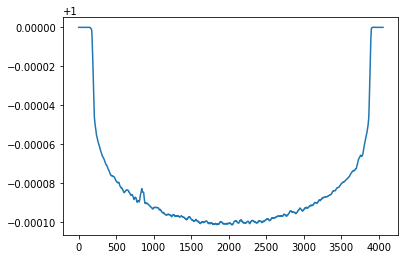

In [11]:
filament_lc = np.load('filament_lc.npy')
control_lc = np.load('control_lc.npy')

times = np.arange(0, len(control_lc)) * time_per_step

plt.plot(filament_lc/filament_lc.max())

filament_lc_test = np.loadtxt('filament_test.txt')

# MANODEEP: here's the test: 
np.testing.assert_allclose(filament_lc_test, filament_lc)

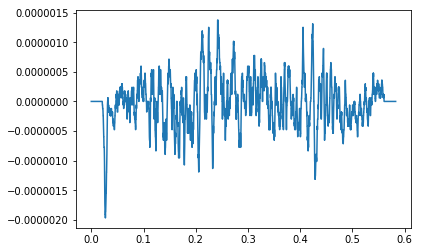

In [6]:
residuals = filament_lc/filament_lc.max() - control_lc/control_lc.max()
plt.plot(times, residuals)
# plt.xlim([0, 0.05])

In [2]:

# from scipy.optimize import fmin_l_bfgs_b, fmin_powell
# import batman
# from copy import deepcopy

# params = batman.TransitParams()
# params.per = 365.25
# params.inc = 89.7
# params.t0 = 0.3
# params.a = float(1*u.AU/R_sun)
# params.u = [0.6, 0.2]
# params.limb_dark = 'quadratic'
# params.rp = float(R_earth/R_sun)
# params.ecc = 0 
# params.w = 90

# def model(p, times):
#     t0, inc, rp, ars, u1, u2 = p
#     trial_params = deepcopy(params)
#     trial_params.t0 = t0
#     trial_params.inc = inc
#     trial_params.u = [u1, u2]
#     trial_params.rp = rp
#     trial_params.a = ars
#     trial_params.limb_dark = 'quadratic'
#     m = batman.TransitModel(trial_params, times)
#     return m.light_curve(trial_params)

# def chi2(p):
#     return np.sum((model(p, times) - control_lc/control_lc.max())**2)

# initp = [0.3, 89.9, params.rp, params.a, 0.5, 0.3]
# bounds = [[0, 1], [80, 90], [0, 1], [200, 300], [-1, 1], [-1, 1]]
# result = fmin_powell(chi2, initp)#, bounds=bounds, approx_grad=True)[0]

# fit = model(result, times)
# print(result)
# plt.plot(times, control_lc/control_lc.max(), '.')
# plt.plot(times, fit)
# plt.show()

# plt.plot(times, control_lc/control_lc.max() - fit)